In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import torch 
torch.cuda.is_available() 

True

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle


In [4]:
# Read the test file, note that it has no labels and needs to be used with your model inference to predict outputs.

def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        batch = pickle.load(fo, encoding='bytes')
    return batch

# Load the batch
cifar10_batch = load_cifar_batch('/kaggle/input/cifar-test/cifar_test_nolabels.pkl')

# Extract images
images = cifar10_batch[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

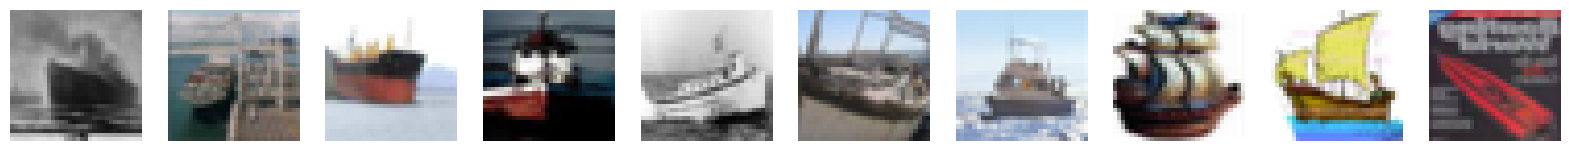

In [5]:
# Extract images and convert back to image format
images = cifar10_batch[b'data']
# Reshape to (number of images, width, height, channels)
images = images.reshape((-1, 3, 32, 32)).transpose(0, 2, 3, 1)

# Display the first 10 images
plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

In [6]:
import os
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import resnet18  # 以ResNet18为基础进行修改
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms import ToPILImage

In [68]:

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# define the transform for train dataset and test dataset
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# upload the dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

# create the train loader and the test loader
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [69]:
import torch.nn as nn

class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size,
                                   stride=stride, padding=padding, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

In [70]:
from torch.nn import Conv2d, BatchNorm2d, ReLU, MaxPool2d, AdaptiveAvgPool2d, Linear
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = self.conv1 = DepthwiseSeparableConv(in_planes, planes, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = DepthwiseSeparableConv(planes, planes, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [71]:
# ResNet Module
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 2*64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 4*64, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 8*64, num_blocks[3], stride=2)
        self.linear = nn.Linear(8*64*block.expansion, num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [72]:
test_loss_history = []
test_acc_history = []


def train(model, device, train_loader, criterion, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_loss_history.append(test_loss)
    test_acc_history.append(correct/len(test_loader.dataset))
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n')


In [29]:
!pip install torchsummary


In [73]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary

block = [3,5,3,0]
model = ResNet(BasicBlock, block).cuda()
summary(model, (3, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]             640
            Conv2d-4           [-1, 64, 32, 32]           4,160
DepthwiseSeparableConv-5           [-1, 64, 32, 32]               0
       BatchNorm2d-6           [-1, 64, 32, 32]             128
            Conv2d-7           [-1, 64, 32, 32]             640
            Conv2d-8           [-1, 64, 32, 32]           4,160
DepthwiseSeparableConv-9           [-1, 64, 32, 32]               0
      BatchNorm2d-10           [-1, 64, 32, 32]             128
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]             640
           Conv2d-13           [-1, 64, 32, 32]           4,160
DepthwiseSeparableConv-14      

In [74]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)


for epoch in range(1, 41):  # 30个训练周期
    train(model, device, train_loader, criterion, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()


Test set: Average loss: 0.0084, Accuracy: 6109/10000 (61%)


Test set: Average loss: 0.0069, Accuracy: 6926/10000 (69%)


Test set: Average loss: 0.0092, Accuracy: 6470/10000 (65%)


Test set: Average loss: 0.0056, Accuracy: 7618/10000 (76%)


Test set: Average loss: 0.0047, Accuracy: 7939/10000 (79%)


Test set: Average loss: 0.0044, Accuracy: 8111/10000 (81%)


Test set: Average loss: 0.0046, Accuracy: 8085/10000 (81%)


Test set: Average loss: 0.0045, Accuracy: 8063/10000 (81%)


Test set: Average loss: 0.0038, Accuracy: 8344/10000 (83%)


Test set: Average loss: 0.0038, Accuracy: 8401/10000 (84%)


Test set: Average loss: 0.0032, Accuracy: 8663/10000 (87%)


Test set: Average loss: 0.0033, Accuracy: 8635/10000 (86%)


Test set: Average loss: 0.0029, Accuracy: 8806/10000 (88%)


Test set: Average loss: 0.0030, Accuracy: 8790/10000 (88%)


Test set: Average loss: 0.0029, Accuracy: 8786/10000 (88%)


Test set: Average loss: 0.0029, Accuracy: 8844/10000 (88%)


Test set: Average loss:

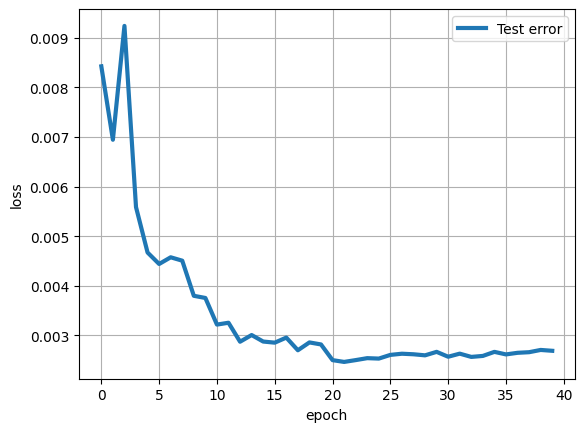

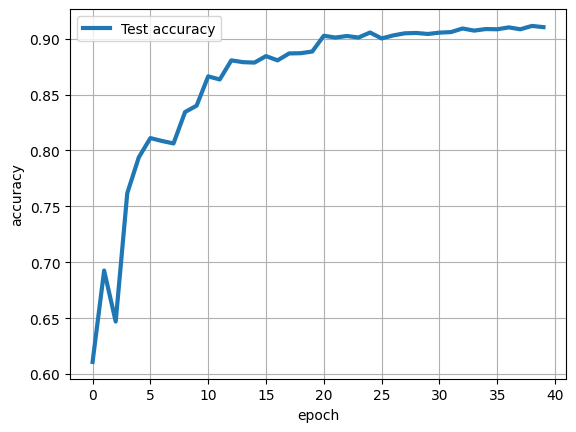

In [75]:
plt.figure()
plt.plot(range(40), test_loss_history, '-', linewidth=3, label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

plt.figure()
plt.plot(range(40), test_acc_history, '-', linewidth=3, label='Test accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid(True)
plt.legend()


In [76]:
import torch
import numpy as np
import pandas as pd

model.eval()

# define the data transform
def transform_test(data):
    data = data.astype(np.float32)
    data /= 255.0
    data = (data - 0.5) / 0.5  #normalization
    data = np.transpose(data.reshape(-1, 3, 32, 32), (0, 2, 3, 1))
    return torch.from_numpy(data)

# the test data
input_data = cifar10_batch[b'data']
input_tensor = transform_test(input_data)

# make the prediction
with torch.no_grad():
    input_tensor=input_tensor.permute(0, 3, 1, 2)
    input_tensor = input_tensor.cuda()
    input_tensor=input_tensor.float()
    output_tensor = model(input_tensor)

predicted_labels = torch.argmax(output_tensor, dim=1)

# change the tensor to the cpu type
predicted_labels = predicted_labels.cpu()

# change the id and the label to the data frame
df = pd.DataFrame({'ID': range(len(predicted_labels)), 'Label': predicted_labels.numpy()})
df.to_csv('submission.csv', index=False)

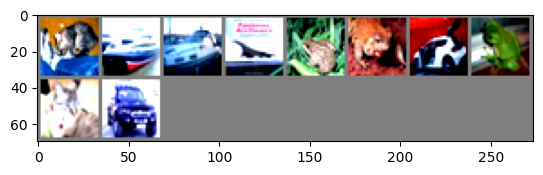

GroundTruth:  cat   ship  ship  plane frog  frog  car   frog  cat   car  
Predicted:    cat   ship  ship  plane frog  frog  car   frog  cat   car  


In [77]:
from torchvision.utils import make_grid
# CIFAR-10 classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Function to unnormalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Only take the first 10 images and labels
images = images[:10]
labels = labels[:10]

# Show images
imshow(make_grid(images))

# Predict the classes
outputs = model(images.to(device))
_, predicted = torch.max(outputs, 1)

# Print actual and predicted classes
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(len(labels))))
print('Predicted:   ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(len(predicted))))